# Introduction

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input, Activation, Dense, Dropout, Flatten, Lambda, LSTM, GRU
from sklearn.metrics import cohen_kappa_score

# Data Importation

In [21]:
dfx = pd.read_csv('x_train.csv').set_index('ID')
dfy = pd.read_csv('y_train.csv').set_index('ID')

In [22]:
dfx.head()

,neuron_id,timestamp_0,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6,timestamp_7,timestamp_8,...,timestamp_40,timestamp_41,timestamp_42,timestamp_43,timestamp_44,timestamp_45,timestamp_46,timestamp_47,timestamp_48,timestamp_49
ID,,,,,,,,,,,,,,,,,,,,,
0,53,0.166262,0.170520,0.176371,0.197565,0.212814,0.957631,1.177679,3.207268,3.213602,...,14.700766,15.856531,15.906414,15.910547,16.079702,16.516175,16.988851,16.996101,17.019988,17.056403
1,7229,0.053270,0.133652,0.161603,0.530531,0.692537,0.730291,0.784066,1.023311,1.059203,...,10.420048,11.577627,18.070029,18.825891,19.248378,19.539560,19.723312,19.978294,20.052356,20.123709
2,7770,0.600593,1.127467,1.289813,2.598660,3.826711,4.851020,5.025722,5.262254,5.282915,...,24.635121,25.967167,26.270768,28.028523,29.584844,31.183257,31.218086,31.285777,33.160938,33.360947
3,7002,0.136037,0.655734,0.992514,1.490964,2.246825,2.855319,3.208054,3.325092,4.202108,...,13.473805,13.688518,14.028203,14.178543,14.783635,15.151632,16.003356,16.282885,17.249543,17.259610
4,7678,0.200614,0.257171,0.288137,0.314078,0.486903,0.499591,0.534961,0.623986,0.639313,...,11.298341,12.214740,13.072630,13.952573,14.013957,14.476091,14.724149,16.883795,17.052340,19.289922


In [25]:
dfy.head()

,TARGET
ID,
0,0
1,0
2,0
3,0
4,1


In [24]:
if dfy.shape[0] == df.shape[0]:
    print("Same number of samples, all good.")
else:
    print("Different number of samples, problem!")

Same number of samples, all good.


# Data Exploration

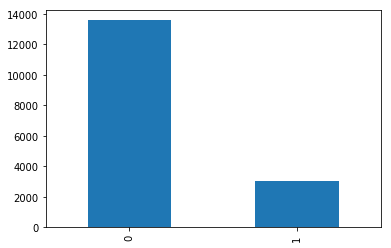

In [43]:
dfy.TARGET.value_counts().plot(kind='bar')
plt.show()

In [44]:
dfx.neuron_id.nunique()

458

In [75]:
# TODO : Make a 3d numpy array from our pandas df
# Shape = [samples, timestamps, features]
arr = dfx.iloc[:,1:].values

# Model Training

## References

* Arxiv: [Neural activity classification with machine learning models trained oninterspike interval series data](https://arxiv.org/pdf/1810.03855.pdf) => PCA and KNN
* Github: [PySpike: Python library to analyze spike Train](https://github.com/mariomulansky/PySpike) => Obscure mathematical measurements between spike trains
* Profil: [Prof expert en spike train analysis](http://xtof.perso.math.cnrs.fr/)

## Code

### Deep-Learning 1: blunt RNN

In [41]:
timestamp_nb = 50
feature_nb = 2

input_shape = (timestamp_nb, feature_nb)
x = input_tensor = Input(input_shape)
x = LSTM(4, return_sequences=False)(x)
x = output_tensor = Dense(1)(x)
model = Model(input_tensor, output_tensor)

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 50, 2)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 4)                 112       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 5         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

### Domain-knowledge 1: KNN with SPIKE- and ISI- synchronization distances